**Подготовка colab notebook**

1.Скопируйте этот colab (go to File-->Save copy in Drive)

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание ShiftLab 2022 Computer Vision [ваше имя фамилия].ipynb" 

например,
"Тестовое задание ShiftLab 2022 Computer Vision Иван Иванов.ipynb"


#Необходимо создать и обучить multi-output классификатор изображений







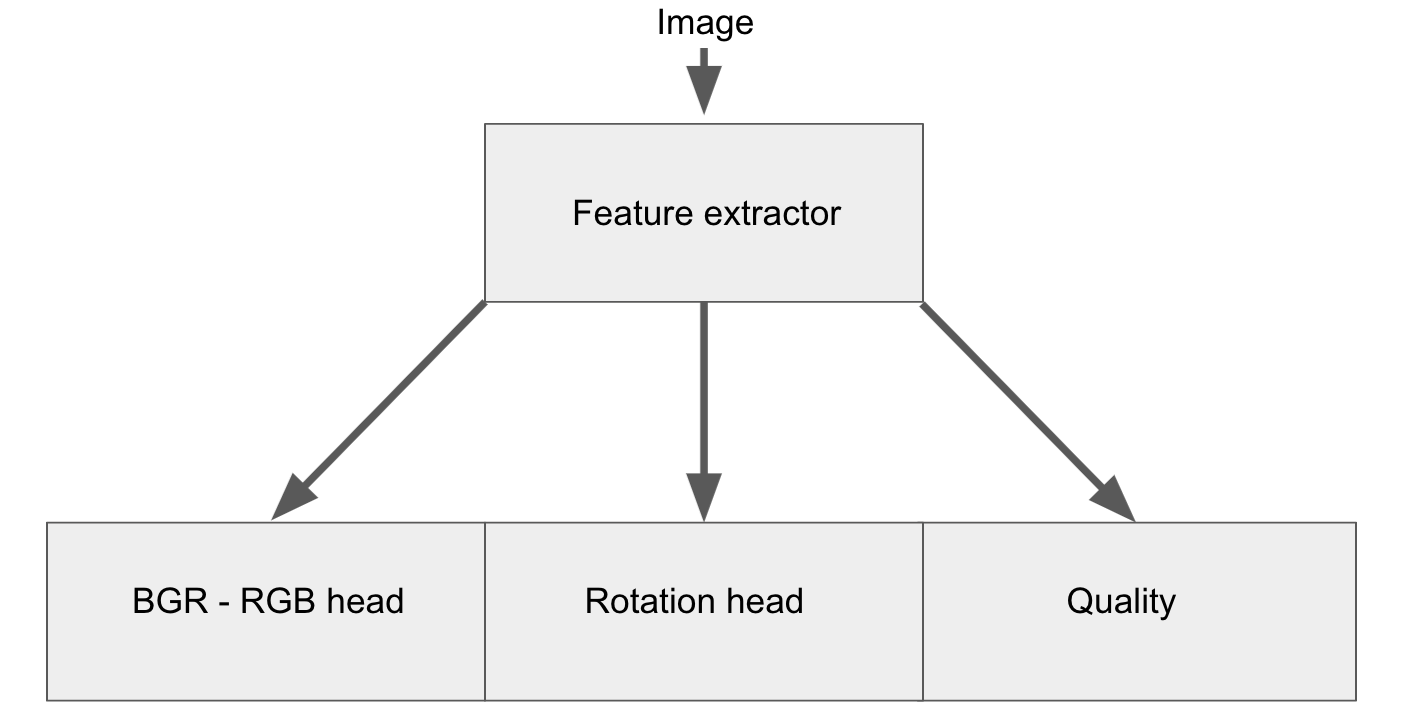

# На вход в классификатор подается изображение, на выходе должны быть вероятности для следующих классов:
### Выход качество: 

классы: 

1. Blur - фото смазано 

2. Torch -  фото засвечено

3. Sharp - фото хорошего качества, резкое

### Выход поворот:

классы: 

1. Поворот отсутствует 0 градусов

2. Поворот по часовой стрелке на 90 градусов

3. Поворот против часовой стрелке на 90 градусов

4. Перевернутое фото 180 градусов


### Выход  RGB-BGR:

классы:

1. RGB

2. BGR




 

## Особенности задания

1. Можно использовать любые открытые датасеты. Ниже найдете пример датасета.
2. Решение должно быть именно Вашим, уникальным и не повторяться с другими участниками.
4. Можно использовать любой удобный фреймворк (Pytorch, FastAI, Keras, Tensorflow)
5.Назовите папку для датасета DATASET_DIR в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset. Так мы сможем быстрее проверить решение


# Как начать


## Загрузка датасета с kaggle

In [1]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

! pip install -q kaggle

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# example downloading dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [01:10<00:00, 21.2MB/s]
100% 1.49G/1.49G [01:10<00:00, 22.8MB/s]


Dataset was cloned after loading, remove extra dirs. And rename dir with dataset will be used.

In [3]:
!mv /content/blur_dataset_scaled /content/a_arestov_images_dataset
!mv /content/a_arestov_images_dataset/defocused_blurred /content/a_arestov_images_dataset/blur 
!rm -rf /content/defocused_blurred
!rm -rf /content/motion_blurred
!rm -rf /content/sharp

## Labels dict

In [ ]:
dataset_dict = {
    'quality': {0: 'blur',   1: 'torch',   2:'sharp'},
    'angle':   {0:  '0',     1: '90r',     2: '90l',   3: '180'}, 
    'format':  {0: 'rgb',    1: 'bgr'}
    }
'''
dataset_dict['quality_alias'] = dict((g, i) for i, g in dataset_dict['quality'].items())
dataset_dict['angle_alias'] = dict((r, i) for i, r in dataset_dict['angle'].items())
dataset_dict['format_alias'] = dict((f, i) for i, f in dataset_dict['format'].items())
'''

# Prepare data

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.lib.display import join
import shutil 
from tqdm import tqdm

## Resizing

In [5]:
path = '/content/a_arestov_images_dataset/'

blur_path = path + 'blur/'
mot_blur_path = path + 'motion_blurred/'
sharp_path = path + 'sharp/'

def resize_dir(dir = blur_path):
    for i, file_name in enumerate(tqdm(os.listdir(dir))):
        img = Image.open(dir+file_name).resize((224,224))
        os.remove(dir+file_name)
        img.save(dir+file_name)

In [6]:
resize_dir(dir = blur_path)
resize_dir(dir = mot_blur_path)
resize_dir(dir = sharp_path)

100%|██████████| 350/350 [00:35<00:00,  9.96it/s]


## Example of image blending

**Summary**: i didn't manage to find any mention of sun glares or whatever applied in python, so i decided to blend sharp pictures and motion blur ones. Photos into dataset are triplet, so we can find pair 'sharp-mot_blur' for every picture (due to there are strictly 350 per triplet) with just sorting content of irs by name (fortunately, images have similar names).

Example is below. 

In [ ]:
n = 124
print(sorted(os.listdir('/content/a_arestov_images_dataset/sharp'))[n])
print(sorted(os.listdir('/content/a_arestov_images_dataset/motion_blurred'))[n])

211_SAMSUNG-GALAXY-7-NEO_S.jpg
211_SAMSUNG-GALAXY-7-NEO_M.jpg


In [ ]:
n = 0
img1 = Image.open(mot_blur_path + \
                  str( sorted(os.listdir(mot_blur_path))[n] )).resize((500,300))
img2 = Image.open(sharp_path + \
                  str( sorted(os.listdir(sharp_path))[n] )).resize((500,300)) # normal sharp
img3 = Image.blend(img1, img2, 1.7)

0_IPHONE-SE_M.JPG
0_IPHONE-SE_S.JPG


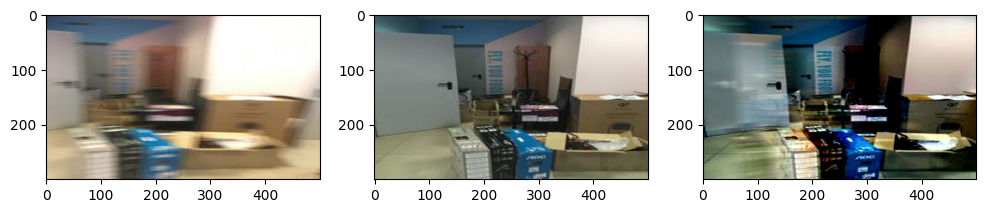

In [ ]:
print(sorted(os.listdir(mot_blur_path))[n])
print(sorted(os.listdir(sharp_path))[n])
fig, ax = plt.subplots(1,3, figsize=(12, 9))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3) # product

## Blending (create 'torched' images)

Expand the sample with 'torch' images:

In [7]:
!mkdir /content/a_arestov_images_dataset/torch

In [8]:
source_mot_blur = path + 'motion_blurred/'
source_sharp = path + 'sharp/'
source_torch = path + 'torch/'

for i, file_name in enumerate(tqdm(os.listdir(source_mot_blur))):
    name, extension = os.path.splitext(file_name)
    blure_img = Image.open(source_mot_blur + \
                  str( sorted(os.listdir(mot_blur_path))[i] ))
    sharp_img = Image.open(source_sharp + \
                  str( sorted(os.listdir(sharp_path))[i] )).resize((224,224)) # normal sharp
    torch_img = Image.blend(blure_img, sharp_img, 1.7) 
    
    # save and label images accoring 'torch' '0 deg' 'BGR'
    torch_img.save(f'{source_torch}/' + f'1_0_1_{i}'+f'{extension}') # torch 0deg bgr

100%|██████████| 350/350 [00:01<00:00, 187.36it/s]


In [9]:
!rm -rf /content/a_arestov_images_dataset/motion_blurred
len(os.listdir(source_torch))

350

## Labelling

In [10]:
def put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        os.rename(source_dir+'/'+file_name, f'{source_dir}/'+ f'{label}{i}'+f'{extension}') 

put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_')  # blur  0deg bgr
put_img_label(source_dir = os.path.join(path, 'sharp'), label = '2_0_1_') # sharp 0deg bgr

100%|██████████| 350/350 [00:00<00:00, 30208.38it/s]


In [ ]:
('1_0_1_') # torch 0deg bgr     ('1_1_1_') # torch 90r bgr      ('1_2_1_') # torch 90l bgr     ('1_3_1_') # torch 180 bgr     
('0_0_1_') # blur  0deg bgr     ('0_1_1_') # blur  90r bgr      ('0_2_1_') # blur  90l bgr     ('0_3_1_') # blur  180 bgr
('2_0_1_') # sharp 0deg bgr     ('2_1_1_') # sharp 90r bgr      ('0_2_1_') # blur  90l bgr     ('0_3_1_') # blur  180 bgr

('1_0_0_') # torch 0deg rgb     ('1_1_0_') # torch 90r rgb      ('1_2_0_') # torch 90l rgb     ('1_3_0_') # torch 180 rgb          
('0_0_0_') # blur  0deg rgb     ('0_1_0_') # blur  90r rgb      ('0_2_0_') # blur  90l rgb     ('0_3_0_') # blur  180 rgb    
('2_0_0_') # sharp 0deg rgb     ('2_1_0_') # sharp 90r rgb      ('2_2_0_') # blur  90l rgb     ('2_3_0_') # blur  180 rgb       

In [11]:
def rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1):
    r90r = img.rotate(-90)
    r90r.save(f'{source_dir}/' + f'{qual_label}_1_{encode_label}_{i}'+f'{extension}')
    r90l = img.rotate(90)
    r90l.save(f'{source_dir}/' + f'{qual_label}_2_{encode_label}_{i}'+f'{extension}')
    r180 = img.rotate(180)
    r180.save(f'{source_dir}/' + f'{qual_label}_3_{encode_label}_{i}'+f'{extension}')

In [12]:
def augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        b, g, r = img.split()
        image_rgb = Image.merge("RGB", (r, g, b))
        image_rgb.save(f'{source_dir}/' + f'{qual_label}_0_0_{i}'+f'{extension}')

        rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1) # for BGR
        rot_aug(image_rgb, i, extension, source_dir, qual_label, encode_label = 0) # for RGB

In [13]:
augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0')
augmentation(source_dir = os.path.join(path, 'sharp'), qual_label = '2')
augmentation(source_dir = os.path.join(path, 'torch'), qual_label = '1')

100%|██████████| 350/350 [00:05<00:00, 63.11it/s]


In [24]:
print((len(os.listdir('/content/a_arestov_images_dataset/blur'))))
print((len(os.listdir('/content/a_arestov_images_dataset/sharp'))))
print((len(os.listdir('/content/a_arestov_images_dataset/torch'))))

2800
2800
2800


## Separating

In [65]:
from IPython.lib.display import join
import numpy as np

!mkdir /content/a_arestov_images_dataset/train
!mkdir /content/a_arestov_images_dataset/valid
!mkdir /content/a_arestov_images_dataset/test

In [64]:
# !rm -rf /content/a_arestov_images_dataset/train
# !rm -rf /content/a_arestov_images_dataset/valid
# !rm -rf /content/a_arestov_images_dataset/test

In [66]:
train_x, train_y = [], []
valid_x, valid_y = [], []
test_x, test_y = [], []

In [67]:
path = '/content/a_arestov_images_dataset/'
dirs = ['blur', 'sharp', 'torch']

train_dir = 'train'
val_dir = 'valid'
test_dir = 'test'

# separate in valid and train
for dir in dirs:
    source_dir = os.path.join(path, dir)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i%10 != 0:
            dest_dir = os.path.join(path+train_dir)
        else:
            dest_dir = os.path.join(path+val_dir)
            name, extension = os.path.splitext(file_name)
            image = np.asarray(Image.open(source_dir+'/'+file_name))
            valid_x.append(image)
            valid_y.append(name.split('_')[:3])
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

# separate in test and train 
source_dir = os.path.join(path, train_dir)
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    if i%8 == 0:
        name, extension = os.path.splitext(file_name)
        dest_dir = os.path.join(path+test_dir)
        image = np.asarray(Image.open(source_dir+'/'+file_name))
        test_x.append(image)
        test_y.append(name.split('_')[:3])
        shutil.move(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
    else:
        # pass (all below are to be erased)
        name, extension = os.path.splitext(file_name)
        image = np.asarray(Image.open(source_dir+'/'+file_name))
        train_x.append(image)
        train_y.append(name.split('_')[:3])

train_x, train_y = np.array(train_x), np.array(train_y)
valid_x, valid_y = np.array(valid_x), np.array(valid_y)
test_x, test_y = np.array(test_x), np.array(test_y)

100%|██████████| 7560/7560 [00:11<00:00, 654.22it/s]


In [75]:
print('Train shapes: ', train_x.shape, train_y.shape)
print('Valid shapes: ', valid_x.shape, valid_y.shape)
print('Test shapes: ', test_x.shape, test_y.shape)

Train shapes:  (6615, 224, 224, 3) (6615, 3)
Valid shapes:  (840, 224, 224, 3) (840, 3)
Test shapes:  (945, 224, 224, 3) (945, 3)


# Модель
Напишите здесь свою модель и визуализацию данных. 
Архитектура любая на ваше усмотрение (CNN, Transformers, SE blocks)
Используйте необходимые метрики, матрицу ошибок для анализа модели

Проверьте модель на тестовых данных 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import requests

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout 
from keras.layers import Flatten, Lambda, Input, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2

%config InlineBackend.figure_format = 'svg'

In [ ]:
inputs = Input(shape = input_shape)

# Category branch
cat = Lambda(lambda z: tf.image.rgb_to_grayscale(z))(inputs)

cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Flatten()(cat)
cat = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Dropout(0.5)(cat)
cat = Dense(lb_cat.classes_.shape[0], activation = 'softmax', name = 'cat')(cat)


#Color branch
col = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D(3)(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Flatten()(col)
col = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization()(col)
col = Dropout(0.5)(col)
col = Dense(lb_col.classes_.shape[0], activation = 'softmax', name = 'col')(col)


model = Model(inputs = inputs, outputs = [cat, col])
losses = {'cat': 'categorical_crossentropy',
         'col': 'categorical_crossentropy'}
loss_weights = {'cat': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('../working/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')

model.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])

history = model.fit(train_x, {'cat': cat_y_train, 'col': col_y_train},
         validation_data = (val_x, {'cat': cat_y_val, 'col': col_y_val}),
         batch_size = 64, epochs = 30, callbacks = [checkpoint])

# Пример датасета 
https://www.kaggle.com/kwentar/blur-dataset









































































































# Контакты

Вопросы можно задать в 
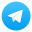


@JI_411

@dragynir


Удачи в выполнении задания!